# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
feat_info.head()


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [8]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,SEMIO_SOZ,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data











The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
#naturally missing data
print("The number of data naturally missing/unknown in each feature:\n{}".format(azdias.isnull().sum()))
print("\nThe total number of data naturally missing/unknown in the data: {}".format(azdias.isnull().sum().sum()))

The number of data naturally missing/unknown in each feature:
AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST

In [10]:
# Identify missing or unknown data values and convert them to NaNs.

for i, missing in zip(range(len(feat_info)), feat_info['missing_or_unknown']):
    att = feat_info.iloc[i]['attribute'] 
    missing = missing.replace('[', '').replace(']', '')
    lst = list(missing.split(","))
    missing_values = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in lst]
    azdias[att].replace(to_replace = missing_values, value = np.NaN, regex = True, inplace = True ) 
    #print(missing_values)
    
print("\nThe total number of the actual missing/unknown in the data: {}".format(azdias.isnull().sum().sum()))



The total number of the actual missing/unknown in the data: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_percentage = azdias.isnull().sum() * 100 / len(azdias)
print(missing_percentage)



AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

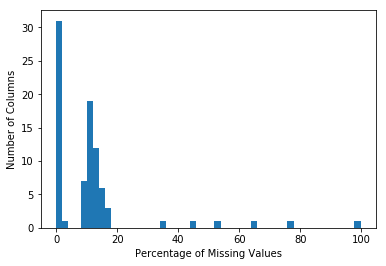

In [12]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_percentage,bins = 50);
plt.ylabel('Number of Columns')
plt.xlabel('Percentage of Missing Values')
plt.show()

In [13]:
#visualizing outliers and missing data percentage
missing_per_column_10 = missing_percentage[missing_percentage>10]
missing_per_column_20 = missing_percentage[missing_percentage>20]
print("Total number of columns: {}".format(len(missing_percentage)))

print("\nNumber of columns missing more than 20% of the data: {}".format(len(missing_per_column_20)))
display(missing_per_column_20.transpose())

print("\nNumber of columns missing more than 10% of the data: {}".format(len(missing_per_column_10)))
display(missing_per_column_10.transpose())

Total number of columns: 85

Number of columns missing more than 20% of the data: 6


AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64


Number of columns missing more than 10% of the data: 46


AGER_TYP                 76.955435
GEBURTSJAHR              44.020282
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
SHOPPER_TYP              12.476816
TITEL_KZ                 99.757636
VERS_TYP                 12.476816
ALTER_HH                 34.813699
KK_KUNDENTYP             65.596749
W_KEIT_KIND_HH           16.605084
ANZ_HAUSHALTE_AKTIV      11.176913
ANZ_HH_TITEL             10.884842
GEBAEUDETYP              10.451729
MIN_GEBAEUDEJAHR         10.451729
OST_WEST_KZ              10.451729
WOHNLAGE                 10.451729
CAMEO_DEUG_2015          11.147852
CAMEO_DEU_2015           11.147852
CAMEO_INTL_2015          11.147852
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
KBA05_ANTG4              14.959701
KBA05_BAUMAX             53.468668
KBA05_GBZ                14.959701
BALLRAUM            

In [14]:
# Remove the outlier columns from the dataset
drop_coloumns = missing_per_column_20.index.tolist()
azdias = azdias.drop(drop_coloumns, axis=1)

print(drop_coloumns)

#Removing the outlier's data from feat_info
to_drop = feat_info.isin (drop_coloumns)
feat_info_updated = feat_info.drop (to_drop [to_drop.attribute == True].index)



['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


#### Discussion 1.1.2: Assess Missing Data in Each Column

We see that the amount of the total missing data is almost double the amount of the naturally missing data, trying to assess the percentage of the missing data in each column we find that almost half the number of the columns(46/85) have more than 10% of their data missing, however only (6/85) columns have extreme percentage of missing data, so they're regarded as outliers and thus removed.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

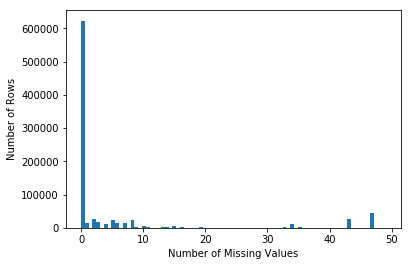

In [15]:
# How much data is missing in each row of the dataset?
missing_per_row =azdias.isnull().sum(axis=1)
plt.hist(missing_per_row, bins=80)
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.show()


In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_updated = azdias[azdias.isnull().sum(axis=1) <= 10]
azdias_more_than_10 = azdias[azdias.isnull().sum(axis=1) > 10]

display (azdias_updated.shape)
display (azdias_more_than_10.shape)

percentage_m10 = len(azdias_more_than_10) *100 / len(azdias)
print("Percentage of rows having less than 10 missing data: {:.2f}%".format(100 - percentage_m10))
print("Percentage of rows having more than 10 missing data: {:.2f}%".format(percentage_m10))


(780153, 79)

(111068, 79)

Percentage of rows having less than 10 missing data: 87.54%
Percentage of rows having more than 10 missing data: 12.46%


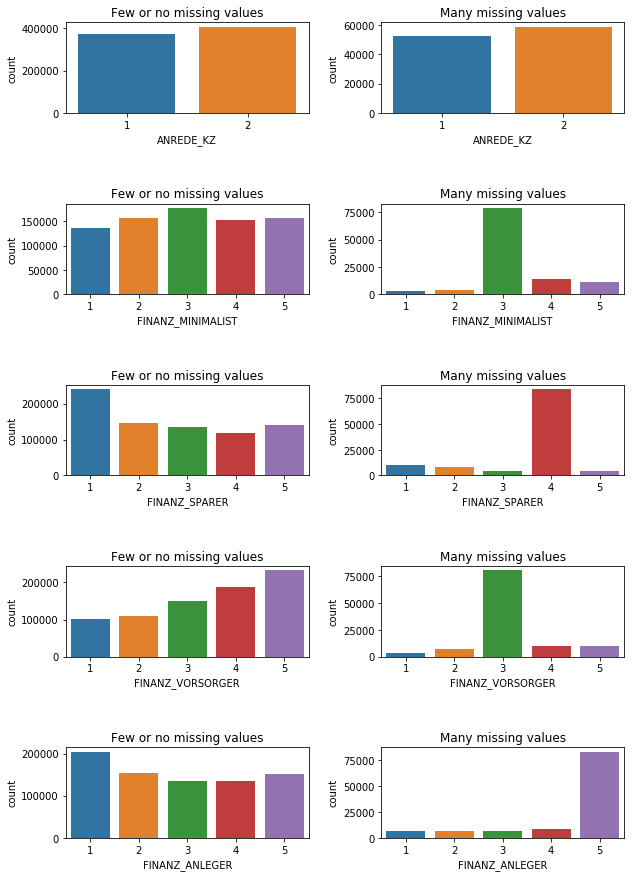

In [17]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

zero_missing_coloumns = missing_percentage[missing_percentage==0].index.tolist()
compare_columns = zero_missing_coloumns[:5]


figure, axs = plt.subplots(nrows=len(compare_columns), ncols=2, figsize = (10,15))
figure.subplots_adjust(hspace = 1, wspace=.3)
for i in range(len(compare_columns)):
    sns.countplot(azdias_updated[compare_columns[i]], ax=axs[i][0])
    axs[i][0].set_title('Few or no missing values')
    sns.countplot(azdias_more_than_10[compare_columns[i]], ax=axs[i][1])
    axs[i][1].set_title('Many missing values')

#### Discussion 1.1.3: Assess Missing Data in Each Row

From the charts above, the distributions of values between the two datasets are similar for Gender feature, but are quite different for some features such as Financial features.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [18]:
# How many features are there of each data type?
num_feat = feat_info_updated.type.value_counts()
display(num_feat)


ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [19]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_features = feat_info_updated [ feat_info_updated['type'] =='categorical']
display (cat_features)

binary_feature = []
multi_level_feature=[]
for feature in cat_features['attribute']:
    if (len(azdias_updated[feature].unique())==2):
        binary_feature.append(feature)
    elif (len(azdias_updated[feature].unique())>2):
        multi_level_feature.append(feature)

print('Binary features are: {} \n {}'.format(len(binary_feature), binary_feature))
print('\nMulti-level features are: {} \n {}'.format(len(multi_level_feature), multi_level_feature))

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


Binary features are: 4 
 ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']

Multi-level features are: 14 
 ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [20]:
# Re-encode categorical variable(s) to be kept in the analysis.
#Re-encoding binary data
for feature in binary_feature:
    print('Unique values for {} are {}'.format(feature, azdias_updated[feature].unique()))


Unique values for ANREDE_KZ are [2 1]
Unique values for GREEN_AVANTGARDE are [0 1]
Unique values for SOHO_KZ are [ 1.  0.]
Unique values for OST_WEST_KZ are ['W' 'O']


In [21]:
azdias_updated['OST_WEST_KZ'] = azdias_updated['OST_WEST_KZ'].replace({'W': 0, 'O': 1})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
#binary data after being updated
for feature in binary_feature:
    print('Unique values for {} are {}'.format(feature, azdias_updated[feature].unique()))

Unique values for ANREDE_KZ are [2 1]
Unique values for GREEN_AVANTGARDE are [0 1]
Unique values for SOHO_KZ are [ 1.  0.]
Unique values for OST_WEST_KZ are [0 1]


In [23]:
#Removing categorical data with more than 10% missing data 
missing_percentage_updated = missing_percentage[multi_level_feature]
valid_multi_level_feature = missing_percentage_updated[missing_percentage_updated<10]
dropped_features = missing_percentage_updated[missing_percentage_updated>10]
print(len(valid_multi_level_feature))
print(valid_multi_level_feature.keys())
print(dropped_features.keys())

azdias_updated = azdias_updated.drop(dropped_features.keys(), axis = 1)

8
Index(['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'ZABEOTYP'],
      dtype='object')
Index(['NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'GEBAEUDETYP',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'],
      dtype='object')


In [24]:
#Re-encoding multi-level data
azdias_updated = pd.get_dummies (azdias_updated, columns = valid_multi_level_feature.keys())
print (azdias_updated.shape)

(780153, 126)


#### Discussion 1.2.1: Re-Encode Categorical Features

After distinguishing the categorical data, they were divided into both binary and multi-levels. The binary data is converted to 0 & 1 and the multi_level data is further inspected.

Because after encoding the data, the dataset will end up having a lot more coloumns(features) which will make it harder for the computing resources while training the model, I decided to drop coloumns having more than 10% missing data.



#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [25]:
#reviewing mixed data
cat_feat_mix = feat_info_updated[feat_info_updated ['type'] =='mixed']
display (cat_feat_mix)

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [26]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_updated['DECADE'] = azdias_updated['PRAEGENDE_JUGENDJAHRE']
azdias_updated['MOVEMENT'] = azdias_updated['PRAEGENDE_JUGENDJAHRE']

decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

azdias_updated['DECADE'].replace(decade_dict, inplace=True)
azdias_updated['MOVEMENT'].replace(movement_dict, inplace=True)

In [27]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_updated['WEALTH'] = azdias_updated['CAMEO_INTL_2015']
azdias_updated['LIFE_STAGE'] = azdias_updated['CAMEO_INTL_2015']
wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}
azdias_updated['WEALTH'].replace(wealth_dict, inplace=True)
azdias_updated['LIFE_STAGE'].replace(life_stage_dict, inplace=True)


#### Discussion 1.2.2: Engineer Mixed-Type Features

To add the additional two dimensions I've added two columns for each of the two mixed features, using the data dictionary I've created a dictionary which maps every number to its corresponding category conded in the form of integer numbers, then replaced each coloumn's data with the corresponding dictionary. The other mixed data will be dropped to decrease the no of features.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [28]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [29]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

mixed_features = feat_info_updated[feat_info_updated["type"]=="mixed"]["attribute"]
for feature in mixed_features:
    azdias_updated.drop(feature, axis=1, inplace=True)

In [30]:
azdias_updated.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,1,0,6.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,1,0,0,0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,1,0,0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,0,2.0,1.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [52]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for i, missing in zip(range(len(feat_info)), feat_info['missing_or_unknown']):
        att = feat_info.iloc[i]['attribute'] 
        missing = missing.replace('[', '').replace(']', '')
        lst = list(missing.split(","))
        missing_values = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in lst]
        df[att].replace(to_replace = missing_values, value = np.NaN, regex = True, inplace = True )
    
    
    # remove selected columns and rows, ...
    #removing rows
    drop_coloumns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(drop_coloumns, axis=1)
    #removing coloumns
    df_updated = df[df.isnull().sum(axis=1) <= 10]
    
    # select, re-encode, and engineer column values.
    #binary levels
    df_updated['OST_WEST_KZ'] = df_updated['OST_WEST_KZ'].replace({'W': 0, 'O': 1})
    
    #multi-levels
    multi_level_feature=[]
    for feature in cat_features['attribute']:
        if (len(df_updated[feature].unique())>2):
            multi_level_feature.append(feature)
    #dropping multi-level features with higher percentage of missing data
    dropped_features = ['NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'GEBAEUDETYP',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    df_updated = df_updated.drop(dropped_features, axis = 1)
    #encoding the valid multi-level features
    valid_multi_level_features = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'ZABEOTYP']
    df_updated = pd.get_dummies (df_updated, columns = valid_multi_level_features)
    
    #Engineering mixed-type features
    df_updated['DECADE'] = df_updated['PRAEGENDE_JUGENDJAHRE']
    df_updated['MOVEMENT'] = df_updated['PRAEGENDE_JUGENDJAHRE']

    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

    df_updated['DECADE'].replace(decade_dict, inplace=True)
    df_updated['MOVEMENT'].replace(movement_dict, inplace=True)
                                 
    df_updated['WEALTH'] = df_updated['CAMEO_INTL_2015']
    df_updated['LIFE_STAGE'] = df_updated['CAMEO_INTL_2015']
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
                   '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
                   '51':5, '52':5, '53':5, '54':5, '55':5}

    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                       '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                       '51':1, '52':2, '53':3, '54':4, '55':5}
    df_updated['WEALTH'].replace(wealth_dict, inplace=True)
    df_updated['LIFE_STAGE'].replace(life_stage_dict, inplace=True) 
                                
    mixed_features = feat_info_updated[feat_info_updated["type"]=="mixed"]["attribute"]
    for feature in mixed_features:
        df_updated.drop(feature, axis=1, inplace=True)
    # Return the cleaned dataframe.
    return df_updated
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [32]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer = Imputer(strategy='mean')
azdias_updated_imputed = pd.DataFrame(imputer.fit_transform(azdias_updated))

print("Number of missing data after applying the imputer: {}".format(azdias_updated_imputed.isnull().sum().sum()))

Number of missing data after applying the imputer: 0


In [33]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_updated_imputed),
                                            columns=azdias_updated.columns,
                                            index=azdias_updated.index)

### Discussion 2.1: Apply Feature Scaling

I've decided to fill the missing data with the mean value using the imputer, the reason why I chose this is that I didn't want to decrease the weight of the features having many missing data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [34]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(azdias_scaled)


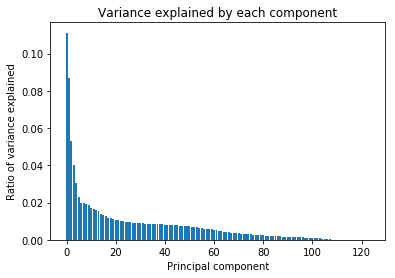

In [35]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()


In [36]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_30= PCA(n_components = 30)
X_pca = pca_30.fit_transform(azdias_scaled)


### Discussion 2.2: Perform Dimensionality Reduction

Judging from variance ratio of the first application of PCA we see that the majority of the variance is contained in the first 30 components so I chose this number of components in the second application of PCA.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [69]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(azdias_scaled.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights
pca_weights(pca_30, 0)

FINANZ_HAUSBAUER        0.209333
HH_EINKOMMEN_SCORE      0.192606
LP_STATUS_GROB_1.0      0.184440
PLZ8_ANTG3              0.179480
LP_STATUS_FEIN_1.0      0.176793
WEALTH                  0.171666
PLZ8_ANTG4              0.170663
KBA05_ANTG4             0.151884
ORTSGR_KLS9             0.145039
EWDICHTE                0.144941
KBA05_ANTG3             0.144301
PLZ8_ANTG2              0.136590
ANZ_HAUSHALTE_AKTIV     0.126398
SEMIO_KAEM              0.122509
ANREDE_KZ               0.118951
SEMIO_KRIT              0.115715
ZABEOTYP_3              0.113023
ARBEIT                  0.111663
LP_FAMILIE_FEIN_1.0     0.111590
LP_FAMILIE_GROB_1.0     0.111590
RELAT_AB                0.111235
MOVEMENT                0.106192
SEMIO_DOM               0.094301
LP_STATUS_GROB_2.0      0.093096
LP_STATUS_FEIN_3.0      0.092349
W_KEIT_KIND_HH          0.090991
SEMIO_ERL               0.085633
ZABEOTYP_6              0.064404
FINANZTYP_1             0.060414
REGIOTYP                0.060231
          

In [38]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(pca_30, 1)

ALTERSKATEGORIE_GROB     0.226099
FINANZ_VORSORGER         0.213490
ZABEOTYP_3               0.202041
SEMIO_ERL                0.175947
RETOURTYP_BK_S           0.158661
SEMIO_LUST               0.158185
W_KEIT_KIND_HH           0.135934
LP_STATUS_FEIN_1.0       0.114035
CJT_GESAMTTYP_2.0        0.104844
FINANZ_HAUSBAUER         0.104735
FINANZTYP_5              0.100122
PLZ8_ANTG3               0.087759
EWDICHTE                 0.083380
PLZ8_ANTG4               0.083359
FINANZTYP_2              0.083171
ORTSGR_KLS9              0.082426
SEMIO_KRIT               0.076829
WEALTH                   0.074885
LP_FAMILIE_GROB_1.0      0.073171
LP_FAMILIE_FEIN_1.0      0.073171
CJT_GESAMTTYP_1.0        0.069699
FINANZ_MINIMALIST        0.067007
KBA05_ANTG4              0.065118
FINANZTYP_6              0.063912
ARBEIT                   0.062304
GFK_URLAUBERTYP_4.0      0.061343
SEMIO_KAEM               0.061334
PLZ8_ANTG2               0.061294
HH_EINKOMMEN_SCORE       0.060860
ANZ_HAUSHALTE_

In [39]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(pca_30, 2)


SEMIO_VERT               0.326457
SEMIO_FAM                0.267806
SEMIO_SOZ                0.263260
SEMIO_KULT               0.259355
FINANZTYP_5              0.139686
FINANZ_MINIMALIST        0.127112
SEMIO_REL                0.119107
ZABEOTYP_1               0.116176
SEMIO_MAT                0.095027
RETOURTYP_BK_S           0.076500
GREEN_AVANTGARDE         0.074470
EWDICHTE                 0.070495
ORTSGR_KLS9              0.070332
W_KEIT_KIND_HH           0.066050
PLZ8_ANTG3               0.055773
PLZ8_ANTG4               0.054850
ZABEOTYP_6               0.053491
LP_STATUS_GROB_5.0       0.052185
LP_STATUS_FEIN_10.0      0.052185
LP_STATUS_FEIN_1.0       0.050269
LP_STATUS_FEIN_3.0       0.045983
FINANZ_VORSORGER         0.043569
PLZ8_ANTG2               0.040929
RELAT_AB                 0.040129
ARBEIT                   0.038700
LP_STATUS_GROB_3.0       0.028597
GFK_URLAUBERTYP_4.0      0.027367
KBA05_ANTG4              0.026223
LP_FAMILIE_GROB_2.0      0.024719
LP_FAMILIE_FEI

### Discussion 2.3: Interpret Principal Components

##### In the first principal component: 
We see that low-income earners and Estimated household net income have the highest positive weights, while gender and combative attitude Personality typology have the highest negative weight.

##### In the second principal component: 
We see that estimated age based on given name analysis and Financial typology with the dimension: be prepared, have the highest positive weights, while the decade of the dominating movement of person's youth have the highest negative weight.

##### In the third principal component: 
We see that dreamful and family-minded personality typologies have the highest positive weights, while gender has combative attitude Personality typology have the highest negative weight.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [40]:
#function to apply and score k-means clustering
def k_mean_scoring(data, n_cluster):
    kmeans = KMeans(n_clusters = n_cluster)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [41]:
sample = X_pca[np.random.choice(X_pca.shape[0], int(X_pca.shape[0]*0.5), replace = False)]

In [42]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and..    
    # compute the average within-cluster distances.
scores = []
cluster_numbers = list(range(5,20))
for center in cluster_numbers:
    scores.append(k_mean_scoring(sample, center))    
    

Text(0,0.5,'SSE')

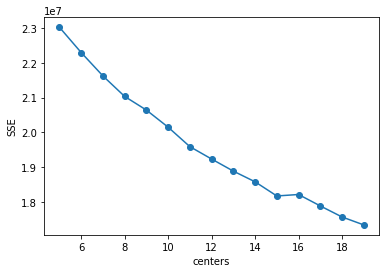

In [43]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(cluster_numbers, scores, linestyle='-', marker='o')
plt.xlabel('centers')
plt.ylabel('SSE')


In [60]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans (n_clusters = 14) 
model = kmeans.fit(X_pca)
azdias_pred = model.predict (X_pca)


### Discussion 3.1: Apply Clustering to General Population

I tried different numbers of clusters ranging from 5 to 20, but trying to run it with the full data took a very long time so I decided to run it over 50% the data, then from the graph I picked the number of clusters at the knee of the graph which was 14 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [45]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

In [53]:
#cleaning the data
customers_cleaned = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [61]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#Removing NANs
customers_cleaned_imputed = pd.DataFrame(imputer.fit_transform(customers_cleaned))
#scaling data 
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_cleaned_imputed),
                                            columns=customers_cleaned.columns,
                                            index=customers_cleaned.index)
#feature reduction
X_pca_customers = pca_30.fit_transform(customers_scaled)

#clustering
customers_pred = customers_model.predict (X_pca_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Clusters')

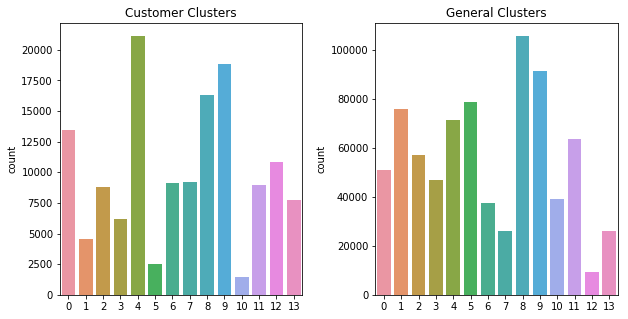

In [62]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(customers_pred, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(azdias_pred, ax=axs[1])
axs[1].set_title('General Clusters')


In [100]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_4 = kmeans.cluster_centers_[4]
centroid_4 = pd.Series(centroid_4)
centroid_4.sort_values(ascending=False, inplace=True)
print("The descending order of the PCAs in the center of the overrepresented centroid:\n{}".format(centroid_4))
print("\n\nThe features contained in the PCA of the maximum value:\n{}".format(pca_weights(pca_30, centroid_4.index[0])))

The descending order of the PCAs in the center of the overrepresented centroid:
5     1.028097
12    0.512981
23    0.493000
8     0.460527
13    0.442195
6     0.436800
14    0.421165
19    0.401503
17    0.322948
21    0.243122
22    0.227683
24    0.028585
16    0.028506
9    -0.042635
25   -0.043692
28   -0.075532
26   -0.080745
29   -0.124488
18   -0.177385
7    -0.288396
27   -0.338136
20   -0.385449
11   -0.427304
15   -0.464955
10   -0.613703
2    -0.706222
4    -0.726442
0    -0.802191
3    -1.024026
1    -4.360119
dtype: float64


The features contained in the PCA of the maximum value:
LP_STATUS_GROB_3.0      0.315052
LP_STATUS_FEIN_7.0      0.267124
LP_STATUS_GROB_2.0      0.215780
ANZ_TITEL               0.195404
KBA13_ANZAHL_PKW        0.183636
PLZ8_HHZ                0.158830
LP_STATUS_FEIN_6.0      0.156105
LP_STATUS_FEIN_3.0      0.155143
PLZ8_GBZ                0.148301
SEMIO_MAT               0.146837
SEMIO_RAT               0.138416
LP_STATUS_FEIN_4.0      0.136260
A

In [101]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_5 = kmeans.cluster_centers_[5]
centroid_5 = pd.Series(centroid_5)
centroid_5.sort_values(ascending=False, inplace=True)
print("The descending order of the PCAs in the center of the overrepresented centroid:\n{}".format(centroid_5))
print("\n\nThe features contained in the PCA of the maximum value:\n{}".format(pca_weights(pca_30, centroid_5.index[0])))

The descending order of the PCAs in the center of the overrepresented centroid:
1     2.714032
2     2.672478
0     2.480442
4     0.832644
12    0.335576
19    0.311117
17    0.232467
23    0.232389
7     0.197803
21    0.188078
18    0.121191
24    0.084531
10    0.075392
22    0.050858
11    0.010482
29   -0.008289
25   -0.029145
28   -0.065602
26   -0.079537
27   -0.093788
6    -0.182062
9    -0.293379
5    -0.311434
20   -0.415213
8    -0.473277
15   -0.477747
16   -0.485898
14   -0.497980
13   -0.591822
3    -0.678270
dtype: float64


The features contained in the PCA of the maximum value:
FINANZ_SPARER            0.273926
FINANZ_ANLEGER           0.269777
DECADE                   0.265317
SEMIO_RAT                0.187743
SEMIO_PFLICHT            0.184586
FINANZ_UNAUFFAELLIGER    0.176783
SEMIO_TRADV              0.138775
ZABEOTYP_4               0.137527
ONLINE_AFFINITAET        0.136787
FINANZTYP_1              0.136490
HEALTH_TYP               0.131063
LP_FAMILIE_GROB_4.0    

### Discussion 3.3: Compare Customer Data to Demographics Data

From analyzing and comparing the clusters we get some very valuable information about the target customers, we see that cluster 4 is overrated while cluster 5 is underrated.

##### Overrated customer top features: 

- Their social status(rough scale) is either independent or average earners, represented by both LP_STATUS_GROB_3.0 and LP_STATUS_GROB_2.0, while their social status(fine scale) is title holder-households, represented by LP_STATUS_FEIN_7.0 feature.
- Number of professional academic title holders in household represented by ANZ_TITEL feature.
- Number of cars in the PLZ8 region represented by KBA13_ANZAHL_PKW feature.

##### Underrated customer top features: 

- Their Financial typology is either money-saver or investor represented by both FINANZ_SPARER and FINANZ_ANLEGER features.
- the decade of the dominating movement of person's youth represented by the DECADE feature.
- Their personality typology is either rational or dutiful represenetd by both SEMIO_RAT and SEMIO_PFLICHT features.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.